<a href="https://colab.research.google.com/github/antounes/deep-learning-fastai-pytorch/blob/main/02_from_model_to_production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Classifying Rock Types with Deep Learning: A Trial"
> "This is the first post of my research work on convolutional neural networks, a family of neural networks mostly used (but not only) for solving computer vision problems."

- toc: true
- badges: false
- show_tags: false
- comments: true

## Introduction

This personal research work should help me getting a sound understanding of how convolutional neural networks work under the hood. Notebooks help mixing computer science practice and deep learning theory.

The goal here is to build a classifier for distinguishing between rock types. Part of my studies focused on Eart Science, and before definitely switching to math and computer science, I spent a decent part of my time as a field geologist student. One of the most tricky parts of the job was identifying rocks, be it directly on the field or after, when back in the lab. 

The image below shows the three major families of rocks geologists distinguish, namely igneous (formed through cooling and solidification of lava), metamorphic (formed by transformation of existing rocks under varying pressure and temperature conditions) and sedimentary (formed by accumulation or deposition of mineral or organic particles).

![](images/rocks.png "From left to right: igneous, metamorphic and sedimentary rocks")

Let's assess if such rocks are understandable and can be represented in such a manner that a neural network can distinguish between their types.

## The Dataset

Our rocks dataset has been prepared by people from the Brac University Mars Rover Team for the purpose of research of similar rocks identification in a mars-like surface and is freely available on [Kaggle](https://www.kaggle.com/salmaneunus/rock-classification). 

The exercice here consists in classifying rocks not only as igneous, sedimentary or metamorphic, but as rock names. Our dataset includes the following rocks for each rock family:
- Igneous: basalt, granite
- Metamorphic: marble, quartzite
- Sedimentary: coal, limestone, sandstone

In [1]:
#hide
!pip install -Uqq fastbook
!pip install -q --upgrade git+https://github.com/fastai/fastai.git
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.4 MB/s 
     |████████████████████████████████| 46 kB 4.2 MB/s 
     |████████████████████████████████| 189 kB 43.8 MB/s 
     |████████████████████████████████| 1.2 MB 27.4 MB/s 
     |████████████████████████████████| 56 kB 4.4 MB/s 
     |████████████████████████████████| 51 kB 305 kB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [ ]:
#hide_input

# Create path and copy images from Google Drive
path = Path('rocks')
!cp -r gdrive/MyDrive/blog/rocks {path}

# Get images for fastai format
fns = get_image_files(path)
print('{} rock images copied to {}'.format(len(fns), path))

# Search for corrupt images
failed = verify_images(fns)
print('{} corrupted file(s)'.format(len(failed)))

# Discard corrupt images if any
if len(failed) > 0:
  failed.map(Path.unlink);

## Preparing Data for Training The Network

### Creating Suitable Data Structures

Convolutional neural networks accept images as inputs. They won't accept jpg, png, or any other image file format though. Generally speaking, when developing deep learning models, our first thoughts must concern data representation, be it technically or conceptually.

Technically, models accept numbers. Deal with it. We'll have to find a way of passing our downloaded images to the model we'll build in a way the model will be able to process them and produce outputs from them.
Conceptually, before diving headfirst in code, carefully thinking of a way of representing raw data can save hours and prevent headaches that could arise when dealing with neural network architecture considerations.

We must also define how to create the sets used for training and evaluating our model. Here, the variable to predict (the *dependent* variable) is a rock name $-$ basalt, granite, marble, quartzite, coal, limestone or sandstone. The inputs used by the model for outputing classifications (the *independent* variables) are rock images. Building the training and validation sets must be carried out carefully, and significant performance improvements can come only from a wise selection of training and validation examples for feeding a network. Here we'll perform random splitting of the images, with a fraction of 20% being used as validation set.

Images downloaded are of different sizes. We can have a look at the size distribution below (for the sake of clarity, only sizes counting more than 10 images have been plotted here). This is a problem since we won't feed our network one image at a time, but rather batches of images (technically we're feeding *mini-batches*, but this will be discussed later). Before grouping it into a structure that can be sliced into such mini-batches, we need to resize the images to the same size.

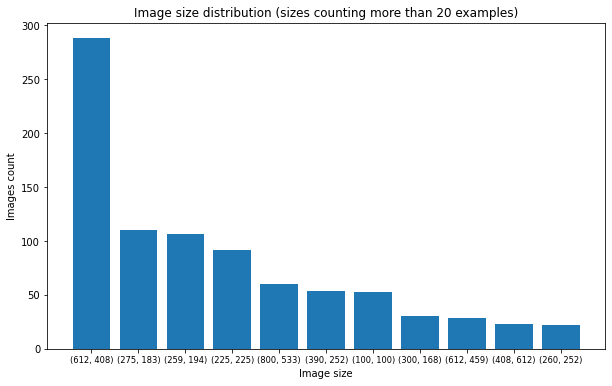

In [4]:
#hide_input

sizes = []
for img in fns:
  try:
    img_size = Image.open(img).size
    sizes.append(img_size)
  except FileNotFoundError:
    pass

counter = collections.Counter(sizes)
counts = {str(k): v for k, v in counter.items() if v > 20}
df = pd.Series(counts).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(range(len(df)), df.values, align='center')
plt.xticks(range(len(df)), df.index.values, size='small')
plt.title('Image size distribution (sizes counting more than 20 examples)');
plt.xlabel('Image size');
plt.ylabel('Images count');
plt.show()

In [5]:
#hide

rocks = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

dls = rocks.dataloaders(path)

When all these preparation steps have been defined and carried out, we're ready to build our data structures and provide them to the network. We can look at a few images from the training and validation batches we just created.

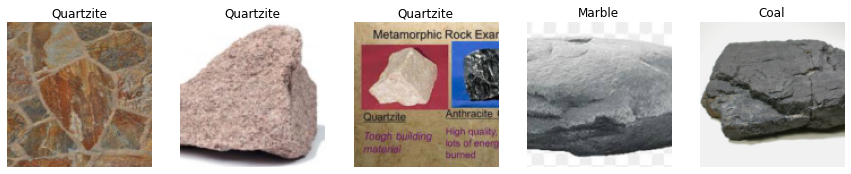

In [6]:
#hide_input

dls.train.show_batch(max_n=5, nrows=1)

Let's pause a second for an important word here: resizing images will somewhat modify the reality. The model will be fed with images that may be cropped, stretched, etc. 

A very crucial point in machine learning (and consequently in deep learning) is that a models cannot perform on concepts they haven't been trained on. Feeding a neural network with black and white images and then trying to produce outputs on never-seen coloured images can only result in poor performance. The goal of deep learning is to find *useful* representations of data, be it in a humanly understandable space or not. Models cannot invent representations while they haven't been trained on, they're just searching for better and more explainable representations of the input data. That's why data preparation is maybe the most important point in building deep learning models.

### Data Augmentation

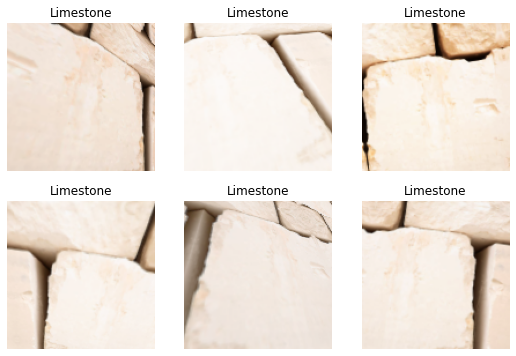

In [7]:
rocks = rocks.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = rocks.dataloaders(path)
dls.train.show_batch(max_n=6, nrows=2, unique=True);

## Training the model

In [8]:
# Use RandomResizedCrop w/ img size of 224x224 (fairly common in CV)
rocks = rocks.new(item_tfms=RandomResizedCrop(224, min_scale=0.5),
                  batch_tfms=aug_transforms())
dls = rocks.dataloaders(path)

In [9]:
# Create learner and fine-tune to our dataset
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.212490,1.189094,0.341404,00:25


epoch,train_loss,valid_loss,error_rate,time
0,1.340979,1.000403,0.322034,00:27
1,1.113590,0.986900,0.292978,00:27
2,0.960208,0.953783,0.290557,00:30
3,0.794850,0.934182,0.285714,00:27


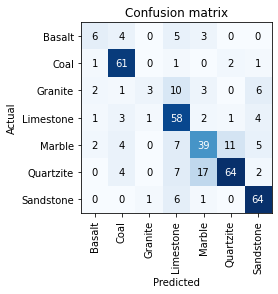

In [10]:
# Plot confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

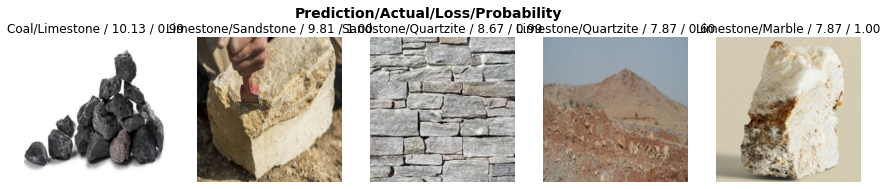

In [24]:
# Plot top losses
interp.plot_top_losses(5, nrows=1)